In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import torch
from torch import nn, optim
import random
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from ipywidgets import FloatProgress


In [43]:

# work
# bw_dir = r"E:\ML_SAR\trials\bnw"
color_dir = r"E:\ML_SAR\coloured_total"

paths = [os.path.join(color_dir, fname) for fname in os.listdir(color_dir)]
print(f"Found {len(paths)} colored images.")


random.seed(42)
total_paths = len(paths)
# Generate a random permutation of indices
indices = list(range(total_paths))
random.shuffle(indices)
print(indices[:10])

# Select the first `train_size` elements for train_paths
train_indices = indices[:12800]

# The rest of the elements go to test_paths
test_indices = indices[12800:]

# Create the train_paths and test_paths based on the shuffled indices
train_paths = [paths[i] for i in train_indices]
val_paths = [paths[i] for i in test_indices]
print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")

Found 15999 colored images.
[8545, 3330, 13368, 3521, 12911, 4491, 13494, 26, 11853, 14003]
Training set size: 12800
Validation set size: 3199


(256, 256, 3)
torch.Size([3, 256, 256])


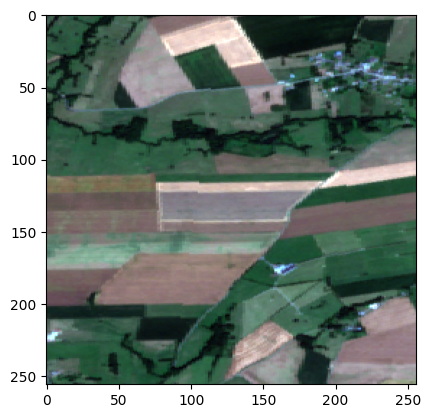

In [44]:
# plt.imshow(Image.open(paths[10]))
img2 = Image.open(paths[10])
plt.imshow(img2)
img2 = img2.convert("RGB")
img3 = rgb2lab(img2).astype("float32")
print(img3.shape)
img_3 = transforms.ToTensor()(img3)
print(img_3.shape)
# plt.imshow(img2)

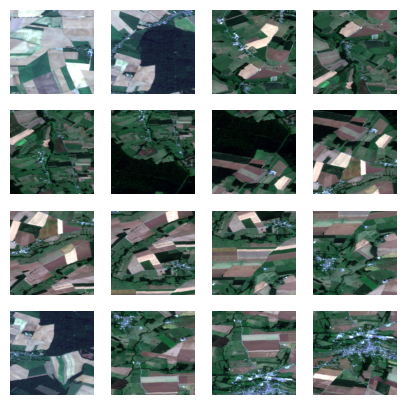

In [45]:
_, axes = plt.subplots(4, 4, figsize=(5, 5))
# x = axes.flatten()
# print(x[])
for ax, img_path in zip(axes.flatten(), paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [46]:
SIZE = 256

class CustomDataset(Dataset):

    def __init__(self, paths):
        self.size = SIZE
        self.paths = paths

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = np.array(img)
        img_lab =  rgb2lab(img).astype("float32")
        img_lab = transforms.ToTensor()(img_lab) #scales n brings in right format of 3 * h * w , but if we do np.array then we 
        # may/may not get h * w * c and value are not scaled 
        L = img_lab[[0], ...] / 50. - 1. #from [0, 100] to [-1, 1]
        ab = img_lab[[1, 2], ...]/110. #from [-110, 110] to [-1, 1]
        return {"L": L, "ab": ab}

In [47]:
def make_dataloaders(batch_size=32, n_workers=4, pin_memory=True, shuffle=True, **kwargs):
    dataset = CustomDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0,
                            pin_memory=pin_memory, shuffle=shuffle)
    return dataloader

In [48]:
train_dl = make_dataloaders(paths=train_paths, shuffle=True)
val_dl = make_dataloaders(paths=val_paths, shuffle=True)

myit = iter(train_dl)
data = next(myit)
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([32, 1, 256, 256]) torch.Size([32, 2, 256, 256])
400 100


In [49]:
data = next(myit)
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
data = next(myit)
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)


torch.Size([32, 1, 256, 256]) torch.Size([32, 2, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 2, 256, 256])


In [50]:
class UNetBlock(nn.Module):
    def __init__(self, nf, ni, submodule = None, input_c = None, dropout = False,
                 innermost = False, outermost = False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                            stride = 2, padding = 1, bias = False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size= 4,
                                        stride = 2, padding = 1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up

        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4, stride = 2, padding = 1, bias = False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = up + down

        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size= 4, stride = 2, padding = 1, bias = False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout:
                up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)


In [51]:
class UNet(nn.Module):
    def __init__(self, input_c = 1, output_c = 2, n_down = 8,
                num_filters = 64):
        super().__init__()
        unet_block = UNetBlock(num_filters* 8, num_filters*8,
        innermost = True)
        for _ in range(n_down - 5):
            unet_block = UNetBlock(num_filters * 8, num_filters* 8,
            submodule = unet_block, dropout = True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UNetBlock(out_filters // 2, out_filters, submodule=
            unet_block)
            out_filters //= 2

        self.model = UNetBlock(output_c, out_filters, input_c=input_c,
                        submodule=unet_block, outermost = True)

    def forward(self, x):
        return self.model(x)

In [52]:
class Discriminator(nn.Module):
    def __init__(self, input_c, num_filters = 64, n_down = 3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm = False)]
        for i in range(n_down):
            stride = 1 if i == (n_down - 1) else 2
            in_channels = num_filters * 2 ** i
            out_channels = num_filters * 2 ** (i + 1)
            model.append(self.get_layers(in_channels, out_channels, s = stride))
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s = 1, norm = False, act = False)]
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k = 4, s = 2, p = 1, norm = True, act= True):
        layers = [nn.Conv2d(ni, nf, k, s, p, bias = not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [53]:
Discriminator(3)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): S

In [56]:
discriminator = Discriminator(3)
# dummy_input = torch.randn(16, 3, 256, 256)
dummy_input = torch.randn(32, 3, 256, 256) # as i have 32 batch size now
out = discriminator(dummy_input)
out.shape

torch.Size([32, 1, 30, 30])

In [57]:
class GANloss(nn.Module):
    def __init__(self, gan_mode = "vanilla", real_label = 1.0, fake_label = 0.0):
        super().__init__()
        self.register_buffer("real_label", torch.tensor(real_label))
        self.register_buffer("fake_label", torch.tensor(fake_label))
        if gan_mode == "vanilla":
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == "lsgan":
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds,labels)
        return loss

    

In [58]:
def init_weights(net, init = "norm", gain = 0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == "norm":
                nn.init.normal_(m.weight.data, mean = 0.0, std = gain)
            elif init == "xavier":
                nn.init.xavier_normal_(m.weight.data, gain = gain)
            elif init == "kaiming":
                nn.init.kaiming_normal_(m.weight.data, a = 0, mode = 'fan_in')

            if hasattr(m,'bias') and m.bias != None:
                nn.init.constant_(m.bias.data, 0.0)
            
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print("model initialized with initialization : ", init)
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model




In [59]:
class MainModel(nn.Module):
    def __init__(self, net_G = None, lr_G = 2e-4, lr_D = 1e-4, beta1 = 0.5, beta2 = 0.999, lambda_L1 = 100.):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(UNet(input_c=1, output_c=2, n_down = 8, num_filters = 64), self.device)
        else:
            self.net_G = net_G.to(self.device)

        self.net_D = init_model(Discriminator(input_c=3, n_down=3, num_filters=64),self.device)
        self.GANcriterion = GANloss(gan_mode="vanilla").to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr = lr_G, betas= (beta1,beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr = lr_D, betas = (beta1, beta2))

    def set_requires_grad(self, model, requires_grad = True):
        for param in model.parameters():
            param.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
    
    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim = 1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim = 1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_real + self.loss_D_fake) * 0.5
        self.loss_D.backward()
        
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim = 1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()



In [61]:
class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.count = 0.0
        self.avg = 0.0
        self.sum = 0.0
    
    def update(self, val, count = 1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
        loss_D_fake = AverageMeter()
        loss_D_real = AverageMeter()
        loss_D = AverageMeter()
        loss_G_GAN = AverageMeter()
        loss_G_L1 = AverageMeter()
        loss_G = AverageMeter()

        return {
        'loss_D_fake' : loss_D_fake,
        'loss_D_real' : loss_D_real,
        'loss_D' : loss_D,
        'loss_G_GAN' : loss_G_GAN,
        'loss_G_L1' : loss_G_L1,
        'loss_G' : loss_G}

def update_losses(model, loss_meter_dict, count):
     for loss_name, loss_meter in loss_meter_dict.items():
          loss = getattr(model, loss_name)
          loss_meter.update(loss.item(), count = count)

def lab_to_rgb(L, ab):
    """
     convert L * ab images to R * G * B images.
     first bring L (lightness) from [-1, 1] to [0, 100].
     bring ab from [-1,1] to [-110, 110].
     concat L and ab so that we now have L * ab images
     then convert each of it to an RGB image
    """
    L = (L + 1.) * 50
    ab = ab * 110
    Lab = torch.cat([L, ab], dim = 1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for image in Lab:
          img_rgb = lab2rgb(image)
          rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis = 0) #rowwise

def visualize(model, data, save = True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color =  model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize= (15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if(save == True):
        fig.savefig(f"colourization_{time.time()}.png")
    
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")


    


In [62]:
def save_checkpoint(model, epoch, loss_meter_dict, file_path=None):
    loss_D_fake = loss_meter_dict['loss_D_fake']
    loss_D_real = loss_meter_dict['loss_D_real']
    loss_D = loss_meter_dict['loss_D']
    loss_G_GAN = loss_meter_dict['loss_G_GAN']
    loss_G_L1 = loss_meter_dict['loss_G_L1']
    loss_G = loss_meter_dict['loss_G']

    if file_path is None:
        file_path = f"checkpoint_epoch_{epoch}.pth"

    checkpoint = {
        'model_state_dict': model.state_dict(),
        'loss_D_fake': loss_D_fake,
        'loss_D_real': loss_D_real,
        'loss_D': loss_D,
        'loss_G_GAN': loss_G_GAN,
        'loss_G_L1': loss_G_L1,
        'loss_G': loss_G}
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved at epoch {epoch}: {file_path}")


In [63]:
def train_model(model, train_dl, epochs, display_every = 100):
    data = next(iter(val_dl))
    for e in range(epochs):
        loss_meter_dict = create_loss_meters()
        i = 0
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs
        
        if (e + 1) % 5 == 0:
            save_checkpoint(model, e + 1, loss_meter_dict)

In [ ]:
model = MainModel()
train_model(model, train_dl, 70)

In [65]:
torch.save(model.state_dict(), "model_state.pth")
print("Model state saved.")
print("hello")


Model state saved.
hello
